In [ ]:
!nvidia-smi

In [9]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import autograd_lib as agl
from torch.autograd.functional import hessian
#from functorch import hessian

In [ ]:
!pip install torchvision==0.9.1
!pip install tqdm


In [4]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def shuffle_labels(labels):
    labels = labels.tolist()
    labels = random.sample(labels, len(labels))
    return torch.tensor(labels)

In [11]:
nw = 0
bs = 64
vsize = 0.2

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

td = datasets.CIFAR10('data', train=True, download=True, transform=transform)
testd = datasets.CIFAR10('data', train=False, download=True, transform=transform)


tl = len(td)
i = list(range(tl))
np.random.shuffle(i)
split = int(np.floor(vsize * tl))
ti, vi = i[split:], i[:split]

training_data = SubsetRandomSampler(ti)
validation_data = SubsetRandomSampler(vi)

train_loader = torch.utils.data.DataLoader(td, batch_size=bs,
    sampler=training_data, num_workers=nw)
#train_loader = torch.utils.data.DataLoader(td, batch_size=batch_size,
 #   sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(td, batch_size=bs, 
    sampler=validation_data, num_workers=nw)
test_loader = torch.utils.data.DataLoader(testd, batch_size=bs, 
    num_workers=nw)

# --------------------------------- shuffle labels------------------------------------------------

for i, (inputs, labels) in enumerate(train_loader):
    labels = shuffle_labels(labels)
    
for i, (inputs, labels) in enumerate(valid_loader):
    labels = shuffle_labels(labels)
    
for i, (inputs, labels) in enumerate(test_loader):
    labels = shuffle_labels(labels)

# --------------------------------- shuffle labels----------------------------------------------------


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
print('debug 2.....')

Files already downloaded and verified
Files already downloaded and verified
debug 2.....


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [14]:
model1 = Net()#.to(device)
criterion = nn.CrossEntropyLoss()
if train_on_gpu:
  model1.cuda()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9) 
print(model1)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch: 0 Training Loss: 2.3024 Test Loss: 2.2999
Epoch: 1 Training Loss: 2.2962 Test Loss: 2.2898
Epoch: 2 Training Loss: 2.2616 Test Loss: 2.2012
Epoch: 3 Training Loss: 2.1385 Test Loss: 2.0746
Epoch: 4 Training Loss: 2.0292 Test Loss: 1.9840
Epoch: 5 Training Loss: 1.9513 Test Loss: 1.9064
Epoch: 6 Training Loss: 1.8725 Test Loss: 1.8149
Epoch: 7 Training Loss: 1.7933 Test Loss: 1.7458
Epoch: 8 Training Loss: 1.7371 Test Loss: 1.7370
Epoch: 9 Training Loss: 1.6943 Test Loss: 1.6808
Epoch: 10 Training Loss: 1.6626 Test Loss: 1.6321
Epoch: 11 Training Loss: 1.6311 Test Loss: 1.6090
Epoch: 12 Training Loss: 1.6048 Test Loss: 1.5746
Epoch: 13 Training Loss: 1.5765 Test Loss: 1.5534
Epoch: 14 Training Loss: 1.5485 Test Loss: 1.5299
Epoch: 15 Training Loss: 1.5279 Test Loss: 1.5206
Epoch: 16 Training Loss: 1.5046 Test Loss: 1.4837
Epoch: 17 Training Loss: 1.4829 Test Loss: 1.4580
Epoch: 18 Training Loss: 1.4639 Test Loss: 1.4535
Epoch: 19 Training Loss: 1.4417 Test Loss: 1.4275
Epoch: 20 

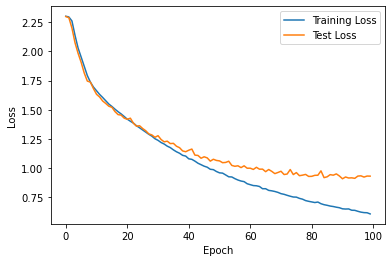

In [15]:
training_losses = []
test_losses = []

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print('Epoch: {} Training Loss: {:.4f} Test Loss: {:.4f}'.format(epoch, training_loss, test_loss))

# Plot the training and test losses
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()